In [2]:
import sys
import os
import src.analyze as analyze
import src.stats_utils as stats_utils
import src.mixtures as mixtures
import src.better_optimiation as bopt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import src.EM as EM
from src.EM import (
    compute_estimate,
    compute_estimate_stable,
    compute_p_at_ks,
    compute_estimates_better_mixture,
)
import src.better_em as BEM
import heapq
import src.bem_geometric as bemg
from src.bem_geometric import (
    compute_estimates_better_three_param_geometric,
    compute_estimates_three_param,
)

/Users/jkazdan/miniforge3/envs/finance/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set model and number of samples

In [3]:
model_name = "Pythia 6.9B"
samples = 50
# define the ks that we will try to predict
ks = np.array([50, 100, 1000, 10000])

Load all data for monkeys power laws

In [4]:
# get data for the number of math problems solved
data = analyze.create_or_load_large_language_monkeys_pythia_math_pass_at_k_df()

# this tells us whether each attempt was a success or failure -- I don't think it adds any
# value given that the attempts were independent
individual_data = (
    analyze.create_or_load_large_language_monkeys_pythia_math_individual_outcomes_df()
)

Loaded /Users/jkazdan/Documents/Research/monkeys/KoyejoLab-Origin-Power-Laws-Scaling-Inference-Compute/data/processed_data/large_language_monkeys_pythia_math_pass_at_k.parquet with shape:  (90496, 7)
Loaded /Users/jkazdan/Documents/Research/monkeys/KoyejoLab-Origin-Power-Laws-Scaling-Inference-Compute/data/processed_data/large_language_monkeys_pythia_math_individual_outcomes.parquet with shape:  (8960000, 5)


In [5]:
data

,Score,Scaling Parameter,Problem Idx,Model,Benchmark,Log Score,Neg Log Score
0,0.0122,1,0,Pythia 12B,MATH,-4.406319,4.406319
1,0.0032,1,1,Pythia 12B,MATH,-5.744604,5.744604
2,0.0167,1,2,Pythia 12B,MATH,-4.092347,4.092347
3,0.0001,1,3,Pythia 12B,MATH,-9.210340,9.210340
4,0.2227,1,4,Pythia 12B,MATH,-1.501930,1.501930
...,...,...,...,...,...,...,...
90491,0.0000,10000,123,Pythia 70M,MATH,-inf,inf
90492,0.0000,10000,124,Pythia 70M,MATH,-inf,inf
90493,0.0000,10000,125,Pythia 70M,MATH,-inf,inf
90494,0.0000,10000,126,Pythia 70M,MATH,-inf,inf


Number of total samples is missing-- fill this in

In [6]:
# label the number of total samples and compute the number of correct attempts for each problem
data["Num. Samples Total"] = 20
data["Num. Samples Correct"] = data["Score"] * data["Num. Samples Total"]
data = data[data["Scaling Parameter"] == 1]

Choose which model to analyze

In [7]:
data

,Score,Scaling Parameter,Problem Idx,Model,Benchmark,Log Score,Neg Log Score,Num. Samples Total,Num. Samples Correct
0,0.0122,1,0,Pythia 12B,MATH,-4.406319,4.406319,20,0.244
1,0.0032,1,1,Pythia 12B,MATH,-5.744604,5.744604,20,0.064
2,0.0167,1,2,Pythia 12B,MATH,-4.092347,4.092347,20,0.334
3,0.0001,1,3,Pythia 12B,MATH,-9.210340,9.210340,20,0.002
4,0.2227,1,4,Pythia 12B,MATH,-1.501930,1.501930,20,4.454
...,...,...,...,...,...,...,...,...,...
77691,0.0000,1,123,Pythia 70M,MATH,-inf,inf,20,0.000
77692,0.0000,1,124,Pythia 70M,MATH,-inf,inf,20,0.000
77693,0.0000,1,125,Pythia 70M,MATH,-inf,inf,20,0.000
77694,0.0000,1,126,Pythia 70M,MATH,-inf,inf,20,0.000


In [8]:
pythia12_math = data[(data["Model"] == model_name)]

In [9]:
pythia12_math

,Score,Scaling Parameter,Problem Idx,Model,Benchmark,Log Score,Neg Log Score,Num. Samples Total,Num. Samples Correct
64640,0.0154,1,0,Pythia 6.9B,MATH,-4.173388,4.173388,20,0.308
64641,0.0076,1,1,Pythia 6.9B,MATH,-4.879607,4.879607,20,0.152
64642,0.0109,1,2,Pythia 6.9B,MATH,-4.518992,4.518992,20,0.218
64643,0.0003,1,3,Pythia 6.9B,MATH,-8.111728,8.111728,20,0.006
64644,0.2319,1,4,Pythia 6.9B,MATH,-1.461449,1.461449,20,4.638
...,...,...,...,...,...,...,...,...,...
64763,0.0192,1,123,Pythia 6.9B,MATH,-3.952845,3.952845,20,0.384
64764,0.0000,1,124,Pythia 6.9B,MATH,-inf,inf,20,0.000
64765,0.0000,1,125,Pythia 6.9B,MATH,-inf,inf,20,0.000
64766,0.0000,1,126,Pythia 6.9B,MATH,-inf,inf,20,0.000


In [10]:
# generate data by hand
samples = 100
questions = 10000
ps = np.clip(np.random.exponential(0.2, questions), 0.0001, 1)
ns = np.ones_like(ps).astype(int) * samples
successes = np.random.binomial(n=ns, p=ps)
pythia12_math = pd.DataFrame(
    {"Num. Samples Correct": successes, "Num. Samples Total": ns}
)

In [11]:
ps

array([0.1612454 , 0.04138034, 0.06793817, ..., 0.21203725, 0.04048865,
       0.31641756])

In [12]:
pythia12_math["Num. Samples Correct"] = successes
pythia12_math["Num. Samples Total"] = ns
pythia12_math["Score"] = successes / ns

In [13]:
discrete_uniform = (
    analyze.fit_discretized_beta_three_parameters_to_num_samples_and_num_successes(
        pythia12_math
    )
)

alpha                 0.550993
beta                   2.06196
loc                        0.0
scale                      1.0
neg_log_likelihood    61.95999
success                Success
dtype: object


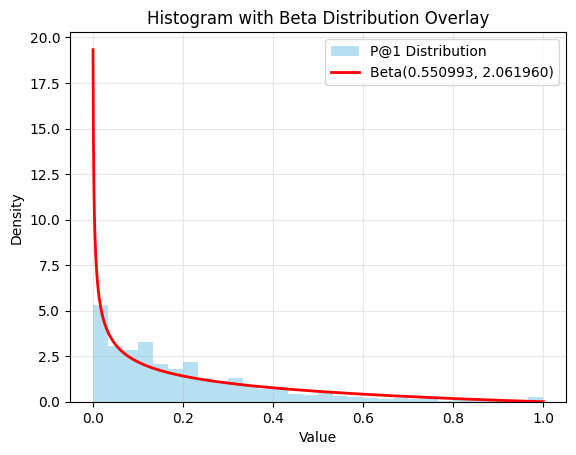

In [243]:
print(discrete_uniform)
stats_utils.plot_histo_and_beta(pythia12_math["Score"], discrete_uniform)

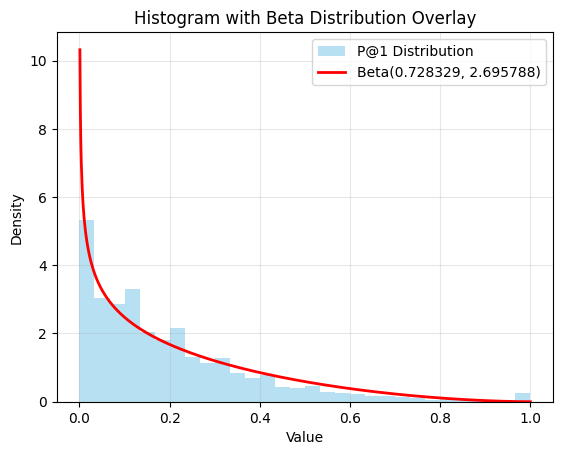

In [244]:
beta2_params = bopt.fit_beta_binomial_two_parameters_stable(pythia12_math)
stats_utils.plot_histo_and_beta(pythia12_math["Score"], beta2_params)

Collect a subset of the data that we use as the training set for prediction

In [6]:
model_ind = individual_data[
    (individual_data["Benchmark"] == "MATH") & (individual_data["Model"] == model_name)
]
model_ind = model_ind[model_ind["Attempt Idx"] <= samples]
model_ind["Num. Samples Correct"] = model_ind.groupby("Problem Idx")["Score"].transform(
    "sum"
)
model_ind["Num. Samples Total"] = samples
smaller_pythia12_math = model_ind

Fit all methods that don't involve mixtures

In [9]:
smaller_beta_2_params = (
    analyze.fit_beta_binomial_two_parameters_to_num_samples_and_num_successes(
        smaller_pythia12_math
    )
)
smaller_beta_2_params_stable = bopt.fit_beta_binomial_two_parameters_stable(
    smaller_pythia12_math
)
# smaller_beta_3_params = analyze.fit_beta_binomial_three_parameters_to_num_samples_and_num_successes(smaller_pythia12_math)
smaller_beta_3_params_stable = bopt.fit_beta_binomial_three_parameters_stable(
    smaller_pythia12_math
)
smaller_beta_3_discretized_params = (
    analyze.fit_discretized_beta_three_parameters_to_num_samples_and_num_successes(
        smaller_pythia12_math
    )
)

In [ ]:
smaller_beta_3_params_stable

Compute the original OpenAI method

In [1]:
# original estimator
ks_fit = np.array([i for i in range(1, samples)])
pass_at_ks = analyze.compute_pass_at_k_from_num_samples_and_num_successes_df(
    smaller_pythia12_math, ks_fit
)
pass_at_ks = pass_at_ks.groupby("Scaling Parameter")["Score"].mean()
model = LinearRegression(fit_intercept=True)
model.fit(np.log(ks_fit).reshape(-1, 1), -np.log(pass_at_ks))
plt.scatter(np.log(ks_fit), -np.log(pass_at_ks))
plt.plot(np.log(ks_fit), model.predict(np.log(ks_fit).reshape(-1, 1)))

NameError: name 'np' is not defined

Compute beta-binomial mixture parameters

In [11]:
n_distr = 1
beta_mixture = BEM.beta_binom_mixture(
    n_distr=n_distr,
    num_successes=smaller_pythia12_math["Num. Samples Correct"],
    num_trials=smaller_pythia12_math["Num. Samples Total"],
)
beta_mixture_params = beta_mixture.fit_mixture()
# beta_mixture_params = EM.fit_beta_binomial_mixture_em(smaller_pythia12_math['Num. Samples Total'], smaller_pythia12_math['Num. Samples Correct'], n_distr)

0: nll: 8458.79308362747
0: nll: 8455.554593844565
0: nll: 8455.554591168875
0: nll: 8455.554587253677
0: nll: 8455.554587253639
0: nll: 8455.554587252625
0: nll: 8455.55458725142
0: nll: 8455.554587177208
0: nll: 8455.55458716587
0: nll: 8455.554587155264
0: nll: 8455.554587142755
0: nll: 8455.554587142593
0: nll: 8455.554587142593
0: nll: 8455.554587142593
0: nll: 8455.554587142593
0: nll: 8455.554587142593
0: nll: 8455.554587142593
0: nll: 8455.554587142593
0: nll: 8455.554587142593
0: nll: 8455.554587142593
0: nll: 8455.554587142593
0: nll: 8455.554587142593
0: nll: 8455.554587142593
0: nll: 8455.554587142593
0: nll: 8455.554587142593
0: nll: 8455.554587142593
0: nll: 8455.554587142593
0: nll: 8455.554587142593
0: nll: 8455.554587142593
0: nll: 8455.554587142593
0: nll: 8455.554587142593
0: nll: 8455.554587142593
0: nll: 8455.554587142593
0: nll: 8455.554587142593
0: nll: 8455.554587142593
0: nll: 8455.554587142593
0: nll: 8455.554587142593
0: nll: 8455.554587142593
0: nll: 8455.55

Sample efficiently by always sampling the question with the lowest success probability so far

In [12]:
individual_data_model = individual_data[(individual_data["Model"] == model_name)]

heap = []
heapq.heapify(heap)
budget = samples * len(pythia12_math)
results = []
for ele in individual_data_model["Problem Idx"].unique():
    heapq.heappush(heap, (0, ele))
total_samples = 0
while total_samples < budget:
    total_samples += 1
    attempts, index = heapq.heappop(heap)
    attempt_index = attempts + 1

    # Check if this attempt exists
    filtered_data = individual_data_model[
        (individual_data_model["Problem Idx"] == index)
        & (individual_data_model["Attempt Idx"] == attempt_index)
    ]

    if filtered_data.empty:
        continue  # Skip if no data for this attempt

    score = filtered_data["Score"].iloc[0]
    attempts += 1

    if score == 0:
        heapq.heappush(heap, (attempts, index))  # Fixed: use 'index' not 'ele'
    else:
        results.append(
            {
                "Problem Idx": index,
                "Num. Samples Total": attempts,
                "Num. Samples Correct": 1,
            }
        )
while heap:
    attempts, index = heapq.heappop(heap)
    results.append(
        {
            "Problem Idx": index,
            "Num. Samples Total": attempts,
            "Num. Samples Correct": 0,
        }
    )
efficient_data = pd.DataFrame(results)

Fit geometric mixture

In [13]:
# beta 2 geometric
n_distr = 1
geom_mix = bemg.beta_geometric_mixture(
    n_distr=n_distr,
    num_successes=efficient_data["Num. Samples Correct"],
    num_trials=efficient_data["Num. Samples Total"],
)
geom_params = geom_mix.fit_mixture()
# beta 3 geometric
smaller_beta_3_params_geometric_stable = bopt.fit_beta_binomial_three_parameters_stable(
    efficient_data
)

0: nll: 265.5962486831369
0: nll: 265.5962484802236
0: nll: 265.5962484800258
0: nll: 265.59624848002517
0: nll: 265.59624848002454
0: nll: 265.59624848002426
0: nll: 265.59624848001766
0: nll: 265.59624848001727
0: nll: 265.5962484800011
0: nll: 265.5962484799966
0: nll: 265.59624847998225
0: nll: 265.59624847997827
0: nll: 265.5962484799782
0: nll: 265.59624847989056
0: nll: 265.59624847989056
0: nll: 265.59624847989056
0: nll: 265.59624847989056
0: nll: 265.59624847989056
0: nll: 265.59624847989056
0: nll: 265.59624847989056
0: nll: 265.59624847989056
0: nll: 265.59624847989056
0: nll: 265.59624847989056
0: nll: 265.59624847989056
0: nll: 265.59624847989056
0: nll: 265.59624847989056
0: nll: 265.59624847989056
0: nll: 265.59624847989056
0: nll: 265.59624847989056
0: nll: 265.59624847989056
0: nll: 265.59624847989056
0: nll: 265.59624847989056
0: nll: 265.59624847989056
0: nll: 265.59624847989056
0: nll: 265.59624847989056
0: nll: 265.59624847989056
0: nll: 265.59624847989056
0: nll:

/Users/jkazdan/miniforge3/envs/finance/lib/python3.12/site-packages/scipy/special/_logsumexp.py:128: RuntimeWarning: invalid value encountered in log
  out = np.log(s)


Compute p@k estimates

In [14]:
pass_at_ks = compute_p_at_ks(pythia12_math, ks)

Compute estimates for all methods

In [15]:
# openai regression predictions
X = ks.reshape(-1, 1)
regression_predictions = np.exp(-model.predict(np.log(X)))
# beta discretized estimates
beta_estimates = [
    compute_estimate(smaller_beta_3_discretized_params, k)
    for k in [50, 100, 1000, 10000]
]
# 2-param binomial mixture
mixture_estimates = [
    compute_estimates_better_mixture(
        smaller_pythia12_math, beta_mixture_params, k, n_distr
    )
    for k in ks
]
# 3-param binomial
beta_3_stable_estimates_better = [
    compute_estimates_three_param(
        smaller_pythia12_math, smaller_beta_3_params_stable, k
    )
    for k in ks
]
# 3-param geometric
three_param_geom_estimates = [
    bemg.compute_estimates_better_three_param_geometric(
        efficient_data, smaller_beta_3_params_geometric_stable, k
    )
    for k in ks
]
# 2-param geometric
geom_correct_estimates = [
    bemg.compute_estimates_better_mixture_geometric(
        efficient_data, geom_params, k, n_distr
    )
    for k in ks
]

0.6409515070651636
0.5402882711922894
0.2844893471415728
0.14566887322821842


Make a graph of the fits

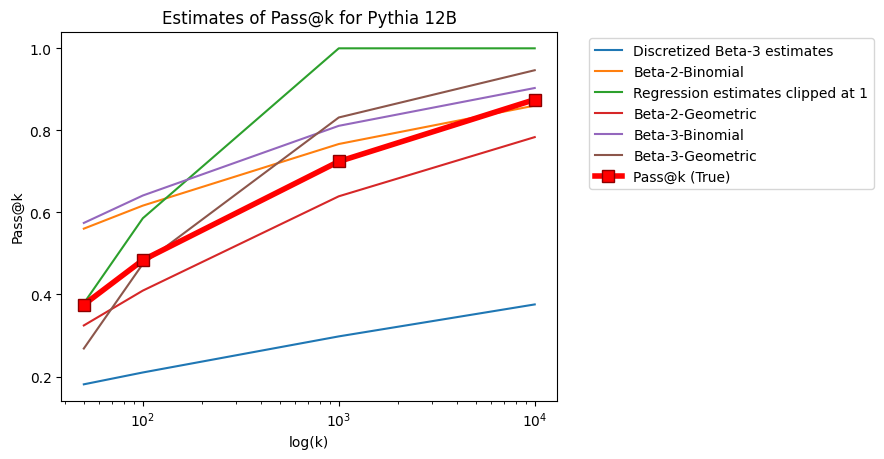

In [17]:
plt.plot(ks, beta_estimates, label="Discretized Beta-3 estimates")
plt.plot(ks, mixture_estimates, label="Beta-2-Binomial")
plt.plot(
    ks, np.clip(regression_predictions, 0, 1), label="Regression estimates clipped at 1"
)
plt.plot(ks, np.clip(geom_correct_estimates, 0, 1), label="Beta-2-Geometric")
plt.plot(ks, beta_3_stable_estimates_better, label="Beta-3-Binomial")
plt.plot(ks, three_param_geom_estimates, label="Beta-3-Geometric")
plt.plot(
    ks,
    pass_at_ks,
    label="Pass@k (True)",
    linewidth=4,
    color="red",
    linestyle="-",
    marker="s",
    markersize=8,
    markerfacecolor="red",
    markeredgecolor="darkred",
)
plt.title(f"Estimates of Pass@k for {model_name}")
plt.ylabel("Pass@k")
plt.xlabel("log(k)")
plt.xscale("log")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")